In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm  
import pandas as pd

In [18]:
P_0_matrix=np.array([[0.005,0.793,0.202],
                   [0.027,0.558,0.415],
                   [0.736,0.249,0.015]])

P_0_matrix


array([[0.005, 0.793, 0.202],
       [0.027, 0.558, 0.415],
       [0.736, 0.249, 0.015]])

In [19]:
P_1_matrix=np.array([[0.718,0.254,0.028],
                   [0.347,0.097,0.556],
                   [0.015,0.956,0.029]])
P_1_matrix

array([[0.718, 0.254, 0.028],
       [0.347, 0.097, 0.556],
       [0.015, 0.956, 0.029]])

In [20]:
action_space=[0,1]
state_space=[0,1,2]
reward_matrix=[[0,0.699],[0,0.362],[0,0.715]]
N=100
M=20
epsilon=0.1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [21]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [22]:
Q_values=[]
for i in range(N):
  Q_values.append([[0,0.699],[0,0.362],[0,0.715]])

In [23]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
  if action==1:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
  else:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)




In [24]:
def act(Q_values,epsilon,state,arm_index):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[arm_index][state])
  return action

In [25]:
alternative_indexes=[0 for _ in range(N)]
current_state=[random.choice([0,1,2]) for _ in range(N)]

In [26]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=0.1

In [27]:
for i in range(1,400001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  alpha=1/(1+(i/5000))
  beta=1/(1+(i*np.log(i)/5000))
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q_values,epsilon,current_state[index],index)
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  #print(reward_sum)

  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)

  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








Text(0.5, 1.0, 'Subsidy vs Steps for Non Indexable Example')

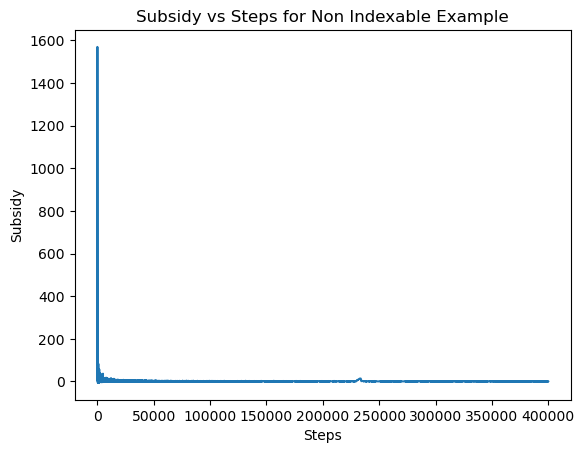

In [28]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Non Indexable Example')

In [29]:
subsidies[-1]

0.6991927432254519

In [30]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of reward for Non Indexable Example ')

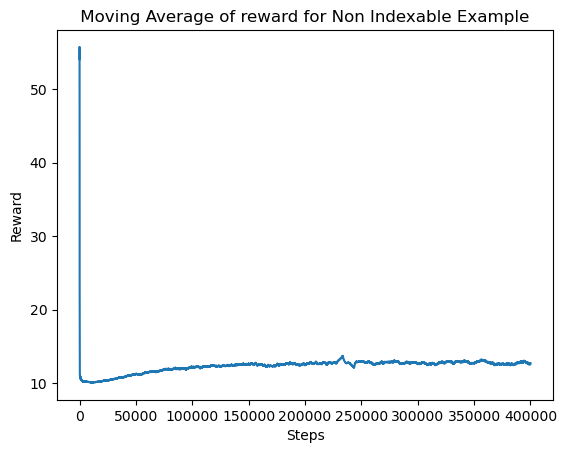

In [35]:
plt.plot(df[0].rolling(10000,min_periods=1).mean())
# plt.axhline(y = 14, color = 'r', linestyle = '-') 
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Non Indexable Example ')


Text(0.5, 1.0, ' Moving Average of number of arms activated for Non Indexable Example ')

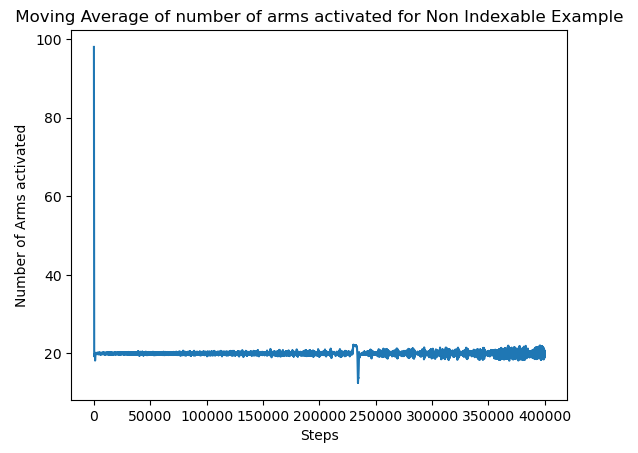

In [32]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Non Indexable Example ')


In [37]:
#using learnt indices
current_state=[0 for _ in range(N)]
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,400001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q_values[index][current_state[index]][1]-Q_values[index][current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)


In [38]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
reward_sums_whittle_index=[]
actual_whittle_indexes=[0.6941985627000107, 0.5085415824511699, 0.41540222368454144]

for i in range(1,400001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Non Whittle Indexable Example ')

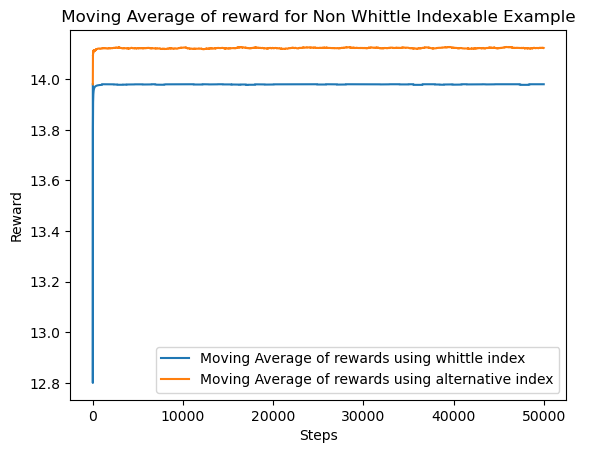

In [40]:
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Non Whittle Indexable Example ')